This notebook downsamples reanalysis dataset from 8,11 to 96,132

Can be used for comparison against WRF

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import cartopy.crs as ccrs  # for plotting map
import cartopy
import matplotlib as mpl
import numpy as np
import scipy.ndimage

import tensorflow as tf
from functions import *

c:\Users\bobby\anaconda3\envs\research\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# raeding reanalysis and WRF data
gefsdir = 'C:\\Users\\bobby\\Desktop\\.vscode\\1 UROP Research\\UROP v2\\raw_preprocessing\\GEFS\\'
reanalysis = xr.open_dataset(gefsdir+'GEFSv12-Reanalysis_tp_2000_2019.nc').sel(lon=slice('102.5', '105.00'), lat=('2.5','2.25','2','1.75','1.5','1.25','1','0.75'))
reforecast_apcp_c00 = xr.open_dataset(gefsdir+'GEFSv12-Reforecast_apcp_c00.nc').sel(longitude=slice('102.5', '105.00'), latitude=('2.5','2.25','2','1.75','1.5','1.25','1','0.75'))
wrfdir = 'C:\\Users\\bobby\\Desktop\\.vscode\\1 UROP Research\\UROP v2\\raw_preprocessing\\WRF\\'
wrf = xr.open_dataset(wrfdir+'d02WRF_tp_2000_2019.nc').isel(south_north=slice(10,106), west_east=slice(18,150))
reanalysis = reanalysis.isel(time=slice(1, None)) 
del reanalysis.attrs['history'] # remove long history text
lon = reanalysis.lon.values
lat = reanalysis.lat.values
# time = np.arange(np.datetime64("2016-12-31T18"), np.datetime64("2020-01-01T00"), np.timedelta64(6, "h"))
time = np.arange(np.datetime64("2000-01-01T06"), np.datetime64("2020-01-01T00"), np.timedelta64(6, "h"))
# time = np.arange(np.datetime64("2000-01-01T06"), np.datetime64("2004-02-09T06"), np.timedelta64(6, "h"))
reforecast_apcp_c00 = reforecast_apcp_c00.resample(time='6H').asfreq()
reforecast_apcp_c00.tp.values = reforecast_apcp_c00.tp.interpolate_na(dim='time')

KeyboardInterrupt: 

In [25]:
# IF REQUIRED TO TAKE SAMPLE

# wrf = wrf.isel(Time=slice(0,6000))
# reanalysis = reanalysis.isel(time=slice(0,6000))
# reforecast_apcp_c00 = reforecast_apcp_c00.isel(time=slice(0,6000))

In [26]:
# bilinear interpolation for lat/lon
bilinear_lon = scipy.ndimage.zoom(lon, 12, order=1)
bilinear_lat = scipy.ndimage.zoom(lat, 12, order=1)
row_meshgrid, col_meshgrid = np.meshgrid(bilinear_lat, bilinear_lon, indexing='ij')

# bilinear interpolation for the reanalysis values
x = reanalysis.tp.values
x.shape
bilinear_gefs = scipy.ndimage.zoom(x, (1,12,12), order=1)

downscaled_reanalysis = xr.Dataset(
                data_vars=dict(
                    tp=(["time", "lon","lat"], bilinear_gefs, {"units":"kgm**-2"})
                ),
                coords=dict(
                    time=(["time"], time),
                    xlon=(["lon","lat"], col_meshgrid),
                    xlat=(["lon","lat"], row_meshgrid),
                ),
                attrs=dict(description="coords with matrices"),
            )

downscaled_reanalysis = downscaled_reanalysis.swap_dims({"lon":"lat", "lat":"lon"})

In [27]:
def make_FSS_loss(mask_size):  # choose any mask size for calculating densities

    def my_FSS_loss(y_true, y_pred):

        # First: DISCRETIZE y_true and y_pred to have only binary values 0/1 
        # (or close to those for soft discretization)
        want_hard_discretization = True

        # This example assumes that y_true, y_pred have the shape (None, N, N, 1).
        
        cutoff = 0.6  # choose the cut off value for discretization   # 0.6 cutoff means 0.6mm/6h above will be considered as rainfall present

        if (want_hard_discretization):
           # Hard discretization:
           # can use that in metric, but not in loss
           y_true_binary = tf.where(y_true>cutoff, 1.0, 0.0)
           y_pred_binary = tf.where(y_pred>cutoff, 1.0, 0.0)

        else:
           # Soft discretization
           c = 10 # make sigmoid function steep
           y_true_binary = tf.math.sigmoid( c * ( y_true - cutoff ))
           y_pred_binary = tf.math.sigmoid( c * ( y_pred - cutoff ))

        # Done with discretization.

        # To calculate densities: apply average pooling to y_true.
        # Result is O(mask_size)(i,j) in Eq. (2) of [RL08].
        # Since we use AveragePooling, this automatically includes the factor 1/n^2 in Eq. (2).
        pool1 = tf.keras.layers.AveragePooling2D(pool_size=(mask_size, mask_size), strides=(1, 1), 
           padding='valid')
        y_true_density = pool1(y_true_binary);
        # Need to know for normalization later how many pixels there are after pooling
        n_density_pixels = tf.cast( (tf.shape(y_true_density)[1] * tf.shape(y_true_density)[2]) , 
           tf.float32 )

        # To calculate densities: apply average pooling to y_pred.
        # Result is M(mask_size)(i,j) in Eq. (3) of [RL08].
        # Since we use AveragePooling, this automatically includes the factor 1/n^2 in Eq. (3).
        pool2 = tf.keras.layers.AveragePooling2D(pool_size=(mask_size, mask_size),
                                                 strides=(1, 1), padding='valid')
        y_pred_density = pool2(y_pred_binary);

        # This calculates MSE(n) in Eq. (5) of [RL08].
        # Since we use MSE function, this automatically includes the factor 1/(Nx*Ny) in Eq. (5).
        MSE_n = tf.keras.losses.MeanSquaredError()(y_true_density, y_pred_density)

        # To calculate MSE_n_ref in Eq. (7) of [RL08] efficiently:
        # multiply each image with itself to get square terms, then sum up those terms.

        # Part 1 - calculate sum( O(n)i,j^2
        # Take y_true_densities as image and multiply image by itself.
        O_n_squared_image = tf.keras.layers.Multiply()([y_true_density, y_true_density])
        # Flatten result, to make it easier to sum over it.
        O_n_squared_vector = tf.keras.layers.Flatten()(O_n_squared_image)
        # Calculate sum over all terms.
        O_n_squared_sum = tf.reduce_sum(O_n_squared_vector)

        # Same for y_pred densitites:
        # Multiply image by itself
        M_n_squared_image = tf.keras.layers.Multiply()([y_pred_density, y_pred_density])
        # Flatten result, to make it easier to sum over it.
        M_n_squared_vector = tf.keras.layers.Flatten()(M_n_squared_image)
        # Calculate sum over all terms.
        M_n_squared_sum = tf.reduce_sum(M_n_squared_vector)
    
        MSE_n_ref = (O_n_squared_sum + M_n_squared_sum) / n_density_pixels
        
        # FSS score according to Eq. (6) of [RL08].
        # FSS = 1 - (MSE_n / MSE_n_ref)

        # FSS is a number between 0 and 1, with maximum of 1 (optimal value).
        # In loss functions: We want to MAXIMIZE FSS (best value is 1), 
        # so return only the last term to minimize.

        # Avoid division by zero if MSE_n_ref == 0
        # MSE_n_ref = 0 only if both input images contain only zeros.
        # In that case both images match exactly, i.e. we should return 0.
        my_epsilon = tf.keras.backend.epsilon()  # this is 10^(-7)

        if (want_hard_discretization):
           if MSE_n_ref == 0:
              return( MSE_n )
           else:
              return( MSE_n / MSE_n_ref )
        else:
           return (MSE_n / (MSE_n_ref + my_epsilon) )

    return my_FSS_loss 

In [28]:
# # sample test if both datasets are same, FSS will give 1. IF ALL DIFFERENT, WILL BE SHOWN 0
# # DISCRETIZATION SET TO TRUE. anything above 0.5mm/6h will be considered as having rainfall

# # TESTING TOY SAMPLE
# mask_size = 3
# x =  np.array([0,0,0,0,0,0,0,0,0])
# x = x.reshape(1,3,3,1)
# x.shape

# y = np.array([0,0,0,1,1,1,1,1,1]).reshape(1,3,3,1)
# y.shape

# FSS = tf.keras.backend.get_value(1 - make_FSS_loss(mask_size)(x, y))
# FSS

In [29]:
mask_size = 3 

fss_lst = []
for i in range(29219):
    FSS = tf.keras.backend.get_value(1 - make_FSS_loss(mask_size)(wrf.RAINNC.isel(Time=i).values.reshape(1,96,132,1), downscaled_reanalysis.tp.isel(time=i).values.reshape(1,96,132,1)))
    fss_lst.append(FSS)

In [30]:
mask_size = 3 
 
fss2_lst = []  # for reanalysis compare with reforecast
for i in range(29219):
    FSS = tf.keras.backend.get_value(1 - make_FSS_loss(mask_size)(reforecast_apcp_c00.tp.isel(time=i).values.reshape(1,8,11,1), reanalysis.tp.isel(time=i).values.reshape(1,8,11,1)))
    fss2_lst.append(FSS)

# fss2_lst

In [31]:
# comparision of the original reanalysis and the downscaled reanalysis
# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3)) # add this statement before your plot
# # reanalysis.isel(time=0).tp.plot(x="xlon", y="xlat", ax=ax1)
# time = 3
# reanalysis.isel(time=time).tp.plot(ax=ax1)
# downscaled_reanalysis.isel(time=time).tp.plot(x="xlon", y="xlat", ax=ax2)
# wrf.isel(Time=time).RAINNC.plot(x="XLONG", y="XLAT", ax=ax3)
# ax1.set_ylim(0.75, 2.5);
# ax1.set_xlim(102.5, 105);
# # left is reanalysis, right is downscaled reanalysis
# fig.tight_layout;

In [32]:
# plt.figure(figsize=(18,6))
# plt.plot(fss_lst)
# plt.title('FSS comparison between WRF and downscaled reanalysis');

In [33]:
# plt.figure(figsize=(18,6))
# plt.plot(fss2_lst)
# plt.title('FSS comparison between reanalysis and reforecast_apcp_c00');

Text(0.5, 1.0, 'WRF vs Downscaled Reanalysis')

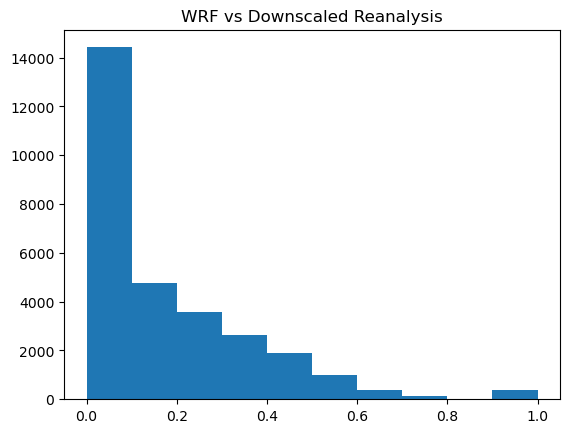

In [34]:
plt.hist(fss_lst)
plt.title('WRF vs Downscaled Reanalysis')

Text(0.5, 1.0, 'GEFS reforecast vs GEFS reanalysis')

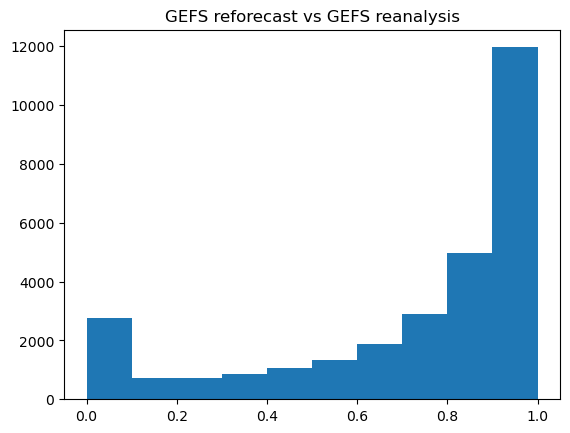

In [35]:
plt.hist(fss2_lst)
plt.title('GEFS reforecast vs GEFS reanalysis')

In [50]:
fss_more = [i for i in fss_lst if i >= 0.6]
print(len(fss_more)/len(fss_lst))

fss2_more = [i for i in fss2_lst if i >= 0.6]
print(len(fss2_more)/len(fss2_lst))

0.030904548410280983
0.7425647694992984


In [51]:
fss_more = [i for i in fss_lst if i >= 0.5]
print(len(fss_more)/len(fss_lst))

fss2_more = [i for i in fss2_lst if i >= 0.5]
print(len(fss2_more)/len(fss2_lst))

0.06560799479790547
0.7886649098189534


In [36]:
# downscaled_reanalysis.tp.plot()

In [37]:
# scaler, downscaled_reanalysis = transform_train(downscaled_reanalysis, 'apcp') # is tp
# scaler_wrf, wrf = transform_train(wrf, 'RAINNC') # is tp

In [38]:
# np.quantile(downscaled_reanalysis.tp.values.reshape(-1), 0.4)

In [39]:
# np.quantile(wrf.RAINNC.values.reshape(-1), 0.8) # 80% contains no rainfall??

In [40]:
# downscaled_reanalysis.tp.plot()

In [41]:
# wrf.RAINNC.plot()

In [42]:
# make_FSS_loss(mask_size)()